In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as sparse

# Machine Learning Modeling
This is a continuation from the first notebook Extraction

## Table of Contents

[Loading in the data from the Extraction notebook.](#Loading)

[Logistical Regression](#Logistical)

[Decision Tree](#decision)

[KNN](#knn)

[Test to with how voting impacts the data](#testing)

<h3> Loading in the data from the Extraction notebook.</h3> <a class="anchor" id="Loading"></a>

In [2]:
df = pd.read_pickle('des_data.pkl')

Altering the two boolean fields to 0 and 1s.

In [3]:
df['elected_y'] = df['elected_y'].astype(int)
df['dissent_x'] = df['dissent_x'].astype(int)

I want to seperate out the test set to be the last election and the bills voted on previously.  So I set it to be the last election as the test and everything not in the test.

In [4]:
mask = df['election_date'] == '2019-10-21'
X_test = df[mask].iloc[:,:-2]
y_test = df[mask].iloc[:,-2]
X_train = df[~(mask)].iloc[:,:-2]
y_train = df[~(mask)].iloc[:,-2]

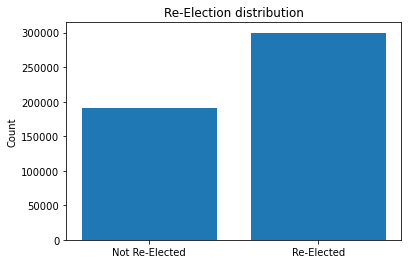

In [18]:
plt.figure()
plt.bar(y_train.value_counts().index, y_train.value_counts())
plt.xticks(ticks = [0,1], labels = ['Not Re-Elected', 'Re-Elected'])
plt.title('Re-Election distribution')
plt.ylabel('Count')
plt.show()

Now I want to convert the party and vote into categorical fields.

In [6]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
party_train = enc.fit_transform(pd.DataFrame(X_train['party_id']))
party_train_df = pd.DataFrame.sparse.from_spmatrix(party_train, columns = enc.get_feature_names(['party'])) 
party_test = enc.transform(pd.DataFrame(X_test['party_id']))
party_test_df = pd.DataFrame.sparse.from_spmatrix(party_test, columns = enc.get_feature_names(['party'])) 
vote_train = enc.fit_transform(pd.DataFrame(X_train['vote_x']))
vote_train_df = pd.DataFrame.sparse.from_spmatrix(vote_train, columns = enc.get_feature_names(['vote'])) 
vote_test = enc.transform(pd.DataFrame(X_test['vote_x']))
vote_test_df = pd.DataFrame.sparse.from_spmatrix(vote_test, columns = enc.get_feature_names(['vote'])) 

Now to remove them the fields that we just vertorized.

In [8]:
X_train.drop(columns = ['vote_x','party_id'], inplace=True)

Now I want to remove dissent and change all the columns to an in16 to reduce the space in memory.  Int16 goes up to 32,767, which will be much higher than we will need.

In [9]:
X_train2 = X_train.drop(columns = 'dissent_x').astype('int16')

Now to join it all together.

In [10]:
voteandparty = pd.concat([vote_train_df,party_train_df], axis = 1)

In [11]:
voteandparty = voteandparty.astype('int16')

In [15]:
stacked = sparse.hstack([voteandparty.sparse.to_coo(), X_train2.sparse.to_coo()])

In [16]:
all_together = pd.DataFrame.sparse.from_spmatrix(stacked, columns = voteandparty.columns.append(X_train2.columns))

In [17]:
all_together

,vote_A,vote_N,vote_P,vote_Y,party_1,party_2,party_3,party_4,party_5,party_9,...,years,yezidis,york,young,youth,yukon,yy,zealand,érable,îles
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491167,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
491168,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
491169,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
491170,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
all_together['vote_P'].mean()

0.006907967066526593

Now to do the same process to the test set.

In [31]:
X_test.drop(columns = ['vote_x','party_id'], inplace=True)

In [32]:
X_test2 = X_test.drop(columns = 'dissent_x').astype('int16')
testvoteandparty = sparse.hstack([vote_test,party_test])
testvoteandparty = testvoteandparty.astype('int16')
stacked = sparse.hstack([testvoteandparty, X_test2.sparse.to_coo()])

In [33]:
testall_together = pd.DataFrame.sparse.from_spmatrix(stacked, columns = voteandparty.columns.append(X_train2.columns))

To export the dataset for Tensorflow, which is why we are using protocol 4 since it uses an earlier version of python.

In [38]:
all_together.to_pickle('sparse_data.pkl', protocol = 4)
y_train.to_pickle('y_train.pkl', protocol = 4)
testall_together.to_pickle('test_spasedata.pkl', protocol = 4)
y_test.to_pickle('y_test.pkl', protocol = 4)

Now to make a baseline, seeing if we guessed the most common value.

In [45]:
y_train.mean()

0.6106231625581263

<h3> Logistical Regression</h3><a class="anchor" id="Logistical"></a>

Lets run a simple logistical regression and see how it does.

In [27]:
from sklearn.linear_model import LogisticRegression
my_model = LogisticRegression(n_jobs=-1, verbose = 1)
my_model.fit(all_together, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s finished


LogisticRegression(n_jobs=-1, verbose=1)

In [28]:
my_model.score(all_together, y_train)

0.6816553060842231

We are 7% above the baseline. so there's some prediction being done.  Let's try to optimize.

In [29]:
from sklearn.model_selection import GridSearchCV
parameters = {'C': [0.01,0.1,1,10,100]}
grid = GridSearchCV(LogisticRegression(max_iter = 5000), parameters, verbose = 1, n_jobs = -1)
grid.fit(all_together, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed: 13.7min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 14.6min finished


GridSearchCV(estimator=LogisticRegression(max_iter=5000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, verbose=1)

In [19]:
grid.best_estimator_

LogisticRegression(C=0.01, max_iter=5000)

In [20]:
grid.score(all_together, y_train)

0.6803624799459252

Our score dropped a little but I think this is due to crossvalidation, we are overfitting a little less.  I tried all the other models and logistical regression performed the best, so let's see how well it did against the test set.

In [34]:
grid.score(testall_together, y_test)

0.7830281935621491

It has a higher accuracy than the test set.  My guess is that our model is latching on to some predictors that is helping it predict.

In [7]:
y_test.mean()

0.8334894150577242

We can see that a lot more MPs were re-elected in our test set.

Let's dive deeper into how are model is predicting.

In [53]:
y_pred = grid.predict(testall_together)

In [54]:
y_pred.mean()

0.862018552914306

Here we can see that we predict based on the test set, our model predicted that 86% would be re-elected. 

We'll now take a look at the classification reports.

In [36]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.32      0.26      0.29     64009
           1       0.86      0.89      0.87    320405

    accuracy                           0.78    384414
   macro avg       0.59      0.57      0.58    384414
weighted avg       0.77      0.78      0.77    384414



In [43]:
y_pred = grid.predict(all_together)
report_initial = classification_report(y_train, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.64      0.41      0.50    191251
           1       0.69      0.85      0.77    299921

    accuracy                           0.68    491172
   macro avg       0.67      0.63      0.63    491172
weighted avg       0.67      0.68      0.66    491172



We can see that our training set still appears to be a little overfitted.  It's appears to be assuming incumbency.

Let's look into the coefficients.  We start first with making the coefficients into a dataframe.

In [47]:
log_coef = pd.DataFrame(grid.best_estimator_.coef_, columns = all_together.columns).T

Now to graph the top 15 and bottom 15.

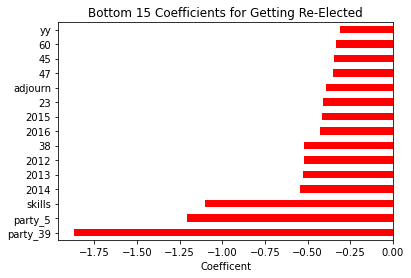

In [65]:
ax = log_coef.sort_values(by=0).head(15).plot(kind='barh', color='r', legend = None)
ax.set_title('Bottom 15 Coefficients for Getting Re-Elected')
ax.set_xlabel('Coefficent');

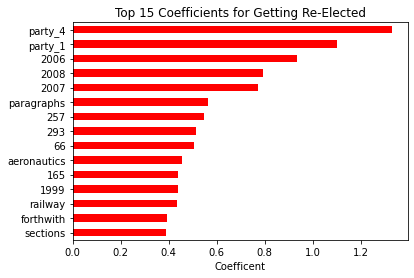

In [66]:
ax = log_coef.sort_values(by=0).tail(15).plot(kind='barh', color='r', legend = None)
ax.set_title('Top 15 Coefficients for Getting Re-Elected')
ax.set_xlabel('Coefficent');

### Decision Tree <a class="anchor" id="decision"></a>

We'll try to optimize Decision Trees

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.pipeline import Pipeline 
estimators = [('reduce_dim', PCA()),
              ('model', svm.SVC())]

pipe = Pipeline(estimators)

param_grid = [
            {'reduce_dim' : [None],
             'model': [DecisionTreeClassifier()], 
             'model__max_depth': [3, 5, 10, 20]
            }
]

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs = -1, verbose = 1)

fittedgrid = grid.fit(all_together, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  5.4min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.7min finished


In [25]:
fittedgrid.score(all_together, y_train)

0.6490862671324913

This performed much worse.

### KNN<a class="anchor" id="knn"></a>

Now to try KNN.  We begin with comparing the two different distance measurement values in KNN.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline 

estimators = [('reduce_dim', TruncatedSVD(n_components = 100)),
              ('model', KNeighborsClassifier(n_jobs=-1))]
pipe = Pipeline(estimators, verbose = 1)
pipe.fit(all_together, y_train)

[Pipeline] ........ (step 1 of 2) Processing reduce_dim, total=  23.4s
[Pipeline] ............. (step 2 of 2) Processing model, total=  33.8s


Pipeline(steps=[('reduce_dim', TruncatedSVD(n_components=100)),
                ('model', KNeighborsClassifier(n_jobs=-1))],
         verbose=1)

In [19]:
pipe.score(all_together, y_train)

0.6770825698533304

In [20]:
estimators = [('reduce_dim', TruncatedSVD(n_components = 100)),
              ('model', KNeighborsClassifier(n_jobs=-1, p = 1))]
pipe = Pipeline(estimators, verbose = 1)
pipe.fit(all_together, y_train)

[Pipeline] ........ (step 1 of 2) Processing reduce_dim, total=  24.5s
[Pipeline] ............. (step 2 of 2) Processing model, total=  31.2s


Pipeline(steps=[('reduce_dim', TruncatedSVD(n_components=100)),
                ('model', KNeighborsClassifier(n_jobs=-1, p=1))],
         verbose=1)

In [21]:
pipe.score(all_together, y_train)

0.6789474970071584

Looks like mahattan distance performs better, lets try to optimize for it.

In [25]:
from sklearn.model_selection import GridSearchCV
estimators = [('reduce_dim', TruncatedSVD()),
              ('model', KNeighborsClassifier(n_jobs=-1))]
pipe = Pipeline(estimators, verbose = 1)
param_grid = [
            {'reduce_dim' : [TruncatedSVD()],
             'reduce_dim__n_components' : [75, 100, 150, 200],
             'model' : [KNeighborsClassifier()], 
             'model__n_neighbors' : [3, 5, 10, 15],
             'model__p' : [1]
            }
]

knngrid = GridSearchCV(pipe, param_grid, cv=3, n_jobs = -1, verbose = 1)

knnfittedgrid = knngrid.fit(all_together, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 94.5min finished


[Pipeline] ........ (step 1 of 2) Processing reduce_dim, total=  33.5s
[Pipeline] ............. (step 2 of 2) Processing model, total=  45.6s


In [26]:
knnfittedgrid.best_estimator_

Pipeline(steps=[('reduce_dim', TruncatedSVD(n_components=200)),
                ('model', KNeighborsClassifier(n_neighbors=3, p=1))],
         verbose=1)

In [27]:
knnfittedgrid.score(all_together, y_train)

0.6766244818515713

Looks like it performs better than Decision Trees but worse than logistical regression. 

### Test to with how voting impacts the data<a class="anchor" id="testing"></a>

I wanted to see if transforming the counts of the vector by how they vote would impact the model, basically putting more of an emphasis on voting.

In [27]:
### This is the clear memory
import gc
gc.collect()

77649

In [25]:
all_together2 = all_together.astype('int8').sparse.to_dense()

In [28]:
all_together2

,vote_A,vote_N,vote_P,vote_Y,party_1,party_2,party_3,party_4,party_5,party_9,...,years,yezidis,york,young,youth,yukon,yy,zealand,érable,îles
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491167,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
491168,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
491169,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
491170,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we want to change it to if they have counted 

In [30]:
all_together2.loc[all_together2.vote_N == 1, '00': 'îles'] = all_together2.loc[all_together2.vote_N == 1, '00': 'îles']*-1

In [31]:
all_together2.loc[all_together2.vote_A == 1, '00': 'îles'] = all_together2.loc[all_together2.vote_A == 1, '00': 'îles']*0

In [32]:
all_together2.loc[all_together2.vote_P == 1, '00': 'îles'] = all_together2.loc[all_together2.vote_P == 1, '00': 'îles']*0

In [33]:
all_together2.drop(columns = ['vote_A','vote_Y', 'vote_P', 'vote_N'],inplace=True)

In [34]:
all_together2

,party_1,party_2,party_3,party_4,party_5,party_9,party_39,00,000,001,...,years,yezidis,york,young,youth,yukon,yy,zealand,érable,îles
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491167,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
491168,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
491169,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
491170,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
all_together3 = all_together2.astype(pd.SparseDtype("int8", 0))

In [36]:
all_together3.dtypes

party_1    Sparse[int8, 0]
party_2    Sparse[int8, 0]
party_3    Sparse[int8, 0]
party_4    Sparse[int8, 0]
party_5    Sparse[int8, 0]
                ...       
yukon      Sparse[int8, 0]
yy         Sparse[int8, 0]
zealand    Sparse[int8, 0]
érable     Sparse[int8, 0]
îles       Sparse[int8, 0]
Length: 5966, dtype: object

In [37]:
from sklearn.linear_model import LogisticRegression
my_model = LogisticRegression(n_jobs=-1, verbose = 1)
my_model.fit(all_together3, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s finished


LogisticRegression(n_jobs=-1, verbose=1)

In [38]:
my_model.score(all_together3,y_train)

0.6311353253035596

We can see it has performed much worse.  Let see how it affected the classification report.

In [41]:
y_pred = my_model.predict(all_together3)

In [42]:
report_initial = classification_report(y_train, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.55      0.28      0.37    191251
           1       0.65      0.85      0.74    299921

    accuracy                           0.63    491172
   macro avg       0.60      0.57      0.56    491172
weighted avg       0.61      0.63      0.60    491172



It looks completely worse than the other one. Let's try to do see what happens if we are just looking at the description language.

In [40]:
all_together3.drop(columns=['party_1', 'party_2','party_3','party_4','party_5','party_9', 'party_39'], inplace = True)

In [41]:
from sklearn.linear_model import LogisticRegression
my_model = LogisticRegression(n_jobs=-1, verbose = 1)
my_model.fit(all_together3, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s finished


LogisticRegression(n_jobs=-1, verbose=1)

In [42]:
my_model.score(all_together3,y_train)

0.6078949940143168

Now our model is performing worse than the mean.  Not much worse, but overall worse.